In [1]:
cd ../Python/

/home/mfruman/DataSci/PBN/Python


In [2]:
import readPBNData.description as rd
import readPBNData.images as ri
import numpy as np

In [3]:
csvs, fileLike = rd.openZip('../Data/train_info.csv.zip')
lines, head = rd.readCSV(fileLike[0])

In [4]:
cols = rd.columns(lines,head)
cols.keys()

['style', 'title', 'artist', 'filename', 'date', 'genre']

In [5]:
# find 10 artists with most paintings in data set
artistTable = rd.table(cols['artist'])
artistTable[:5]

[('3cc9a44380296d93e68b71a27643c25f', 413),
 ('96e7b1bc8d52e18caf0af34fec2e9bcb', 402),
 ('d8a3c897c506be7de91d8f892f14f934', 401),
 ('3f8dc381ccfe9d5cc88b75970262715b', 400),
 ('10bc951c2eb4a2f05fa773bdaace4e3b', 397)]

In [6]:
# images in train_1.zip and train_2.zip file
train_1_names = rd.imagesInZip('../Data/train_1.zip')
train_2_names = rd.imagesInZip('../Data/train_2.zip')

In [95]:
# show (full) image
def showImage(imgName):
    if (imgName in train_1_names):
        ri.openZipImage('../Data/train_1.zip', \
                        imgName, \
                        prefix='train_1' \
                       ).show()
    else:
        ri.openZipImage('../Data/train_2.zip', \
                        imgName, \
                        prefix='train_2' \
                       ).show()

In [7]:
# number of paintings by artist in train_1 and train_2
# distinct artists (slowish)
distinctArtists = [a[0] for a in artistTable]
paintingsIn12 = []
for artist in distinctArtists:
    paintingsIn12.append(len(rd.sameArtist(artist, cols, imageList=train_1_names))
                        +len(rd.sameArtist(artist, cols, imageList=train_2_names)))
artistTable12 = sorted(zip(distinctArtists, paintingsIn12), 
                       key=lambda item: item[1], reverse=True)
artistTable12[:10]

[('0eeac4ecff259dc515be795e1a76019a', 119),
 ('dd4989789d310581024ae2b9203d5439', 111),
 ('121fffad1eb6f7dff228b8a71b6aec72', 105),
 ('1a8d67dbb446bdc4298cc0be56932a38', 104),
 ('ce3d8977aae5986601232aa58d15282a', 103),
 ('c16781c4321948227193214b68477a5c', 101),
 ('3cc9a44380296d93e68b71a27643c25f', 100),
 ('d09f796f2b0aa11dffc88badd9806119', 100),
 ('5aabfc58470d01bb2362795a44a2603b', 99),
 ('db1318d32df7428076e03513ebf762bb', 98)]

In [8]:
# lists of paintings by the 10 "leading" artists in train_1 and train_2 
leaders = [a[0] for a in artistTable12[:10]]
portfolios1 = []
portfolios2 = []
for artist in leaders:
    portfolios1.append(rd.sameArtist(artist, cols, imageList=train_1_names))
    portfolios2.append(rd.sameArtist(artist, cols, imageList=train_2_names))
portfolios = zip(leaders,portfolios1,portfolios2)

In [9]:
# create miniatures of the paintings by leading artists and save them to disk
miniportfolios = []
for portfolio in portfolios:
    minifiles_1 = ri.miniatures('../Data/train_1.zip', \
                                portfolio[1],prefix='train_1',size=(100,100))
    minifiles_2 = ri.miniatures('../Data/train_2.zip', \
                                portfolio[2],prefix='train_2',size=(100,100))
    miniportfolios.append((portfolio[0],minifiles_1,minifiles_2))

In [10]:
# create cutouts of the paintings by leading artists and save them to disk
cutoutportfolios = []
for portfolio in portfolios:
    cutoutfiles_1 = ri.cutouts('../Data/train_1.zip', \
                               portfolio[1],prefix='train_1',size=(100,100))
    cutoutfiles_2 = ri.cutouts('../Data/train_2.zip', \
                               portfolio[2],prefix='train_2',size=(100,100))
    cutoutportfolios.append((portfolio[0],cutoutfiles_1,cutoutfiles_2))

In [11]:
# prepare 1000 pairs of paintings by same artist 
# and 1000 pairs by different artists
import random
npairs = 1000
randomSeed = 666
random.seed(randomSeed)
portfolios_uni = [(artist, p1 + p2) for (artist,p1,p2) in portfolios]
pairs = []
for isample in xrange(npairs):
    # randomly choose an artist
    portfolio = random.choice(portfolios_uni)
    # randomly choose two paintings
    paintings = random.sample(portfolio[1],2)
    pairs.append([paintings[0],paintings[1],1])
for isample in xrange(npairs):
    # randomly choose two artists
    portfoliopair = random.sample(portfolios_uni,2)
    # randomly choose a painting from each artist
    paintings = random.choice(portfoliopair[0][1]), random.choice(portfoliopair[1][1])
    pairs.append([paintings[0],paintings[1],0])

In [12]:
pairs[:8]

[['28512.jpg', '1744.jpg', 1],
 ['26672.jpg', '2113.jpg', 1],
 ['11130.jpg', '26235.jpg', 1],
 ['2238.jpg', '27608.jpg', 1],
 ['10029.jpg', '28898.jpg', 1],
 ['22874.jpg', '10541.jpg', 1],
 ['20277.jpg', '16302.jpg', 1],
 ['17786.jpg', '10316.jpg', 1]]

In [13]:
# load all miniatures and simplify colour palette to 16-colour CGA
# save filenames and pixel-counts by colour in two lists
import PBNFeatures.paletteTools as pt
import os.path
from PIL import Image
featureDir='../Data/FeatureData/'
nc = 16
palette = pt.CGApalette(ncolours=nc)
data = []
names = []
for portfolio in portfolios_uni:
    for painting in portfolio[1]:
        names.append(painting)
        mininame = os.path.splitext(painting)[0] + '_mini_100_x_100.jpg'
        mini = Image.open(featureDir + mininame)
        minip = pt.paletteConvert(mini,palette)
        colours = pt.completeColours(minip.getcolors(),nc)[:nc]
        data.append([c[0] for c in colours])


In [14]:
# load a single pair of miniatures
def loadPair(pair, mc = 'mini'):
    import os.path
    import PIL.Image as Image
    featureDir = '../Data/FeatureData/'
    name0 = os.path.splitext(pair[0])[0] + '_' + mc + '_100_x_100.jpg'
    mini0 = Image.open(featureDir + name0)
    name1 = os.path.splitext(pair[1])[0]+'_' + mc + '_100_x_100.jpg'
    mini1 = Image.open(featureDir + name1)
    return mini0, mini1

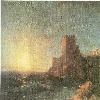

In [15]:
mini1, mini2 = loadPair(pairs[999])
mini1

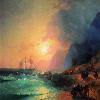

In [16]:
mini2

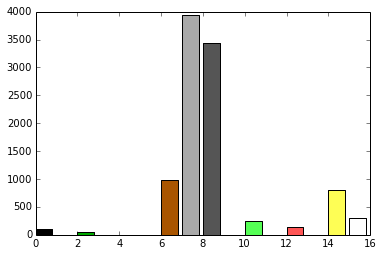

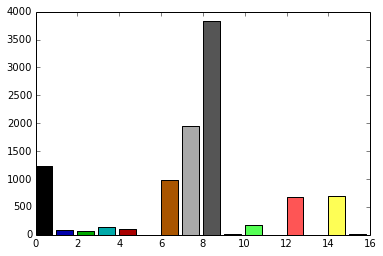

In [17]:
# compare colour distribution in simplified palette between
# members of the pair
%matplotlib inline
import matplotlib.pyplot as plt
palette = pt.CGApalette(ncolours=16)
mini1p = pt.paletteConvert(mini1,palette)
mini2p = pt.paletteConvert(mini2,palette)
pt.plotColourDistribution(mini1p.getcolors(),pt.unflatten(palette))
pt.plotColourDistribution(mini2p.getcolors(),pt.unflatten(palette))
plt.show()

mean distance for sames, diffs:
(15307250.902000001, 16186985.088)




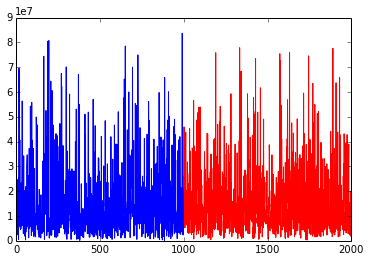

In [18]:
# for all pairs in "pairs", compute distances in colour space
import math
distance = []
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    distance.append(sum((x1-data[inds[1]][i])**2 for i,x1 in enumerate(data[inds[0]])))
print('mean distance for sames, diffs:')
print(np.mean(distance[:npairs]), np.mean(distance[-npairs:]))
print('\n')

# plot Euclidean distance in pixel-count space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (not very exciting!)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance[:npairs],color='blue')
plt.plot(range(npairs,2*npairs),distance[-npairs:],color='red')
plt.show()

mean distance for sames, diffs:
(632.45799999999997, 635.56799999999998)




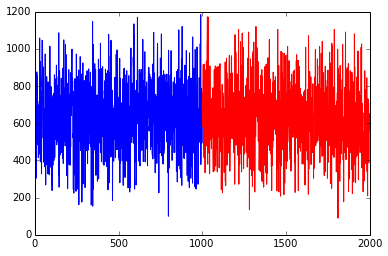

In [19]:
# repeat with a different norm ... (but which?)
# what about just rank difference by colour
distance2 = []
ncol = len(data[0])
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    ranks1 = [aa[1] for aa in sorted(zip(data[inds[0]],range(ncol)))]
    ranks2 = [aa[1] for aa in sorted(zip(data[inds[1]],range(ncol)))]
    distance2.append(sum((r - ranks2[i])**2 for i,r in enumerate(ranks1)))
print('mean distance for sames, diffs:')
print(np.mean(distance2[:npairs]), np.mean(distance2[-npairs:]))
print('\n')

# plot rank distance in pixel-count space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (not exciting at all!!)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance2[:npairs],color='blue')
plt.plot(range(npairs,2*npairs),distance2[-npairs:],color='red')
plt.show()

mean distance for sames, diffs:
(2.3809999999999998, 2.6280000000000001)




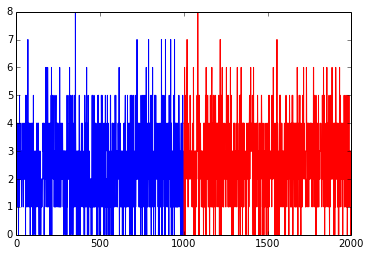

In [20]:
# repeat with yet another different norm ... (but which?)
# what about on/off switch if colour is more than 5%
distance3 = []
ncol = len(data[0])
thresh = 0.05*sum(data[0])
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    onoff1 = [int(x>thresh) for x in data[inds[0]]]
    onoff2 = [int(x>thresh) for x in data[inds[1]]]
    distance3.append(sum((r - onoff2[i])**2 for i,r in enumerate(onoff1)))
print('mean distance for sames, diffs:')
print(np.mean(distance3[:npairs]), np.mean(distance3[-npairs:]))
print('\n')

# plot distance in threshold space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (slightly more exciting :-())
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance3[:npairs],color='blue')
plt.plot(range(npairs,2*npairs),distance3[-npairs:],color='red')
plt.show()

mean distance for sames, diffs:
(3.056, 2.9220000000000002)




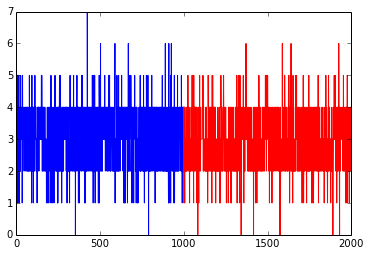

In [21]:
# repeat with yet another different norm ... (but which?)
# what about on/off switch if colour is more than 5%
# but this time count only common colours
distance4 = []
ncol = len(data[0])
thresh = 0.05*sum(data[0])
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    onoff1 = [int(x>thresh) for x in data[inds[0]]]
    onoff2 = [int(x>thresh) for x in data[inds[1]]]
    distance4.append(sum(int(r+onoff2[i]==2) for i,r in enumerate(onoff1)))
print('mean distance for sames, diffs:')
print(np.mean(distance4[:npairs]), np.mean(distance4[-npairs:]))
print('\n')

# plot distance in threshold space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (slightly more exciting :-())
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance4[:npairs],color='blue')
plt.plot(range(npairs,2*npairs),distance4[-npairs:],color='red')
plt.show()

In [96]:
# Was ist hier eigentlich los????
# Let's look at a few particular pairs
pairnum = 7
inds = names.index(pairs[pairnum][0]), names.index(pairs[pairnum][1])

# show (full) images
showImage(pairs[pairnum][0])
showImage(pairs[pairnum][1])

# distance1
print('Euclidean')
print(zip(data[inds[0]],data[inds[1]]))
print(distance[pairnum])

# distance2
print('\nRank')
ranks1 = [aa[1] for aa in sorted(zip(data[inds[0]],range(ncol)))]
ranks2 = [aa[1] for aa in sorted(zip(data[inds[1]],range(ncol)))]
print(zip(ranks1,ranks2))
print(distance2[pairnum])


# distance3
print('\nThreshold')
onoff1 = [int(x>thresh) for x in data[inds[0]]]
onoff2 = [int(x>thresh) for x in data[inds[1]]]
print(zip(onoff1,onoff2))
print(distance3[pairnum])

# distance4
print('\nCommon Threshold')
onoff1 = [int(x>thresh) for x in data[inds[0]]]
onoff2 = [int(x>thresh) for x in data[inds[1]]]
print(zip(onoff1,onoff2))
print(distance4[pairnum])

Euclidean
[(4401, 326), (16, 0), (389, 0), (127, 0), (0, 189), (0, 37), (19, 1813), (218, 1331), (4760, 4226), (1, 0), (50, 0), (2, 0), (1, 1725), (0, 0), (5, 324), (11, 29)]
24629548

Rank
[(4, 1), (5, 2), (13, 3), (9, 9), (12, 10), (11, 11), (14, 13), (15, 15), (1, 5), (6, 4), (10, 14), (3, 0), (7, 7), (2, 12), (0, 6), (8, 8)]
304

Threshold
[(1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0)]
4

Common Threshold
[(1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0)]
1


In [79]:
# maybe hue/saturation/value is more interesting!!!
import PBNFeatures.cylindrical as cyl
reload(cyl)

pairnum=111

# show (full) images
showImage(pairs[pairnum][0])
showImage(pairs[pairnum][1])

# load miniatures
mini1,mini2 = loadPair(pairs[pairnum],mc='mini')

# compute hue/saturation/value statistics
hsvstats1 = cyl.hsv_stats(cyl.jpg_to_hsv(mini1),hue_bins=8)
hsvstats2 = cyl.hsv_stats(cyl.jpg_to_hsv(mini2),hue_bins=8)

hsvstats1, hsvstats2

In [ ]:
# compute PCA for 16-colour CGA colour distributions in miniatures
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PBNFeatures.paletteTools as pt
import PBNPCA.pca as pbnpca
import os.path
import PIL.Image as Image
#import math
palette = pt.CGApalette(ncolours=16)
nc = len(palette)/3
featureDir = '../Data/FeatureData/'

In [ ]:
# compute the PC of data
reload(pbnpca)
ncomp = 15
pobj = pbnpca.pca(np.array(data),ncomp)

# pc:
pcs = []
for col in xrange(ncomp-1,-1,-1):
    # column to row
    pc = [vec[col] for vec in pobj['eigvecs']]
    # construct a "colours" list out of the pc (clumsy but should be okay)
    pc = [(a,i) for i,a in enumerate(pc)]
    pcs.append(pc)

In [ ]:
# plot leading eigenvectors (PC)
pt.plotColourDistribution(pcs[0],pt.unflatten(palette))
pt.plotColourDistribution(pcs[1],pt.unflatten(palette))
pt.plotColourDistribution(pcs[2],pt.unflatten(palette))
pt.plotColourDistribution(pcs[3],pt.unflatten(palette))
pt.plotColourDistribution(pcs[4],pt.unflatten(palette))
pt.plotColourDistribution(pcs[5],pt.unflatten(palette))
plt.show()

In [ ]:
# project row onto leading PC
pbnpca.pcaProject(data[750],pobj)[-8:]

In [ ]:
# compare full vector and projection onto first 8
print(data[750])
print('\n')
print(pbnpca.pcaTrunc(data[750],pobj,8))

#np.zeros((len(data[0]),1))
#np.array(pobj['meanvec']).reshape((len(data[0]),1))

In [ ]:
import random
a = random.sample(range(100),10)
order = [aa[1] for aa in sorted(zip(a,range(len(a))))]
print(a)
print(order)

In [ ]:
int(7<5)

In [ ]:
sum(data[0])

In [ ]:
# ideas for other features ...
#    saturation, lightness
#    texture, edges, dots
#    size
#    number of significant colours
# neural network idea?  (Auto-encoder-decoder)
# topic (=style) modelling